In [19]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import Dropout

import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

import sklearn.metrics as metrics
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna import Trial

import seaborn as sns


In [4]:



# PREPARE DATA(MIX all files in z)
# REF: https://github.com/mmalekzadeh/sensplit
def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("data_subjects_info.csv")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}
sdt = ["attitude", "userAcceleration",'gravity','rotationRate']
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS 
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration', 'gravity', 'rotationRate']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 19)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,act,id,weight,height,age,gender,trial
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.0,0.0,102.0,188.0,46.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.0,0.0,102.0,188.0,46.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.0,0.0,102.0,188.0,46.0,1.0,1.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,0.0,0.0,102.0,188.0,46.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.0,0.0,102.0,188.0,46.0,1.0,1.0


In [5]:
dataset


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,act,id,weight,height,age,gender,trial
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.0,0.0,102.0,188.0,46.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.0,0.0,102.0,188.0,46.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.0,0.0,102.0,188.0,46.0,1.0,1.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,0.0,0.0,102.0,188.0,46.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.0,0.0,102.0,188.0,46.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412860,-2.368280,-0.381075,-0.089417,0.000789,-0.005937,-0.004355,-0.648402,0.371919,0.664267,-0.001312,-0.011512,0.001284,5.0,23.0,74.0,173.0,18.0,0.0,13.0
1412861,-2.368752,-0.381071,-0.089478,-0.000409,-0.000608,0.000098,-0.648090,0.371915,0.664574,-0.000293,-0.022169,0.001305,5.0,23.0,74.0,173.0,18.0,0.0,13.0
1412862,-2.369130,-0.381163,-0.089465,-0.000486,0.000711,0.002045,-0.647814,0.372000,0.664795,0.007208,-0.012616,0.003482,5.0,23.0,74.0,173.0,18.0,0.0,13.0
1412863,-2.369372,-0.381295,-0.089468,0.000311,-0.003395,0.004746,-0.647619,0.372123,0.664916,0.006180,-0.003029,0.004531,5.0,23.0,74.0,173.0,18.0,0.0,13.0


In [6]:
train = dataset[dataset['trial'] < 10]
test = dataset[dataset['trial'] > 10]
train = train.drop(columns = 'trial' , axis = 1)
test = test.drop(columns = 'trial', axis = 1)


In [7]:
train

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,act,id,weight,height,age,gender
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.0,0.0,102.0,188.0,46.0,1.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.0,0.0,102.0,188.0,46.0,1.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.0,0.0,102.0,188.0,46.0,1.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,0.0,0.0,102.0,188.0,46.0,1.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.0,0.0,102.0,188.0,46.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409474,-2.563484,-0.149645,-0.322130,0.049642,-0.097665,-0.050611,-0.540334,0.149087,0.828138,0.401247,0.090453,0.019268,5.0,23.0,74.0,173.0,18.0,0.0
1409475,-2.559251,-0.157457,-0.316592,0.030589,0.012596,-0.037675,-0.543177,0.156807,0.824845,0.473556,0.182187,-0.073280,5.0,23.0,74.0,173.0,18.0,0.0
1409476,-2.554478,-0.161579,-0.309695,0.039482,-0.001026,-0.031796,-0.546746,0.160877,0.821698,0.292846,0.185526,-0.218756,5.0,23.0,74.0,173.0,18.0,0.0
1409477,-2.549122,-0.163005,-0.302709,-0.035492,0.042978,0.010931,-0.551010,0.162284,0.818567,0.261119,0.238936,-0.227592,5.0,23.0,74.0,173.0,18.0,0.0


In [8]:
test

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,act,id,weight,height,age,gender
4209,0.086504,-1.172129,1.181660,-0.067855,-0.048792,0.413061,0.033538,0.921579,-0.386739,1.461974,-4.623707,1.674768,0.0,0.0,102.0,188.0,46.0,1.0
4210,0.059454,-1.146609,1.248254,-0.160289,-0.187298,0.645487,0.024456,0.911373,-0.410853,0.969699,-4.170838,1.271234,0.0,0.0,102.0,188.0,46.0,1.0
4211,0.029339,-1.130040,1.295114,-0.217700,-0.262095,0.587390,0.012515,0.904429,-0.426440,0.704113,-3.355548,0.880569,0.0,0.0,102.0,188.0,46.0,1.0
4212,-0.004340,-1.119799,1.327633,-0.186981,-0.207996,0.391212,-0.001892,0.900013,-0.435860,0.353412,-3.073109,0.617112,0.0,0.0,102.0,188.0,46.0,1.0
4213,-0.041066,-1.118417,1.351262,-0.153762,-0.193431,0.464860,-0.017945,0.899410,-0.436738,-0.076783,-2.783454,0.482344,0.0,0.0,102.0,188.0,46.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412860,-2.368280,-0.381075,-0.089417,0.000789,-0.005937,-0.004355,-0.648402,0.371919,0.664267,-0.001312,-0.011512,0.001284,5.0,23.0,74.0,173.0,18.0,0.0
1412861,-2.368752,-0.381071,-0.089478,-0.000409,-0.000608,0.000098,-0.648090,0.371915,0.664574,-0.000293,-0.022169,0.001305,5.0,23.0,74.0,173.0,18.0,0.0
1412862,-2.369130,-0.381163,-0.089465,-0.000486,0.000711,0.002045,-0.647814,0.372000,0.664795,0.007208,-0.012616,0.003482,5.0,23.0,74.0,173.0,18.0,0.0
1412863,-2.369372,-0.381295,-0.089468,0.000311,-0.003395,0.004746,-0.647619,0.372123,0.664916,0.006180,-0.003029,0.004531,5.0,23.0,74.0,173.0,18.0,0.0


In [9]:
cat_features = ['id','age', 'gender']
num_features = ['attitude.roll',
       'attitude.pitch', 'attitude.yaw', 'userAcceleration.x',
       'userAcceleration.y', 'userAcceleration.z', 'gravity.x', 'gravity.y',
       'gravity.z', 'rotationRate.x', 'rotationRate.y', 'rotationRate.z']

In [10]:
def feature_eng(df, pred, cat, num):
    
    df_ = df.copy()
    
    # label encoder for features
    transformer = make_column_transformer((OneHotEncoder(), cat_features),remainder='passthrough')
    transformed = transformer.fit_transform(df_)
    df_ = pd.DataFrame(transformed, columns = transformer.get_feature_names())
    
    
    for i in num_features:
        df_.insert(1, f'{i}_rmean', df_[i].rolling(50).mean())
        df_.insert(2, f'{i}_rstd', df_[i].rolling(50).std())
        df_.insert(3, f'{i}_rmed', df_[i].rolling(50).median())

    df_ = df_.dropna()
    
    # label encoder for predicition
    LE = LabelEncoder()
    LE.fit(df_[pred])
    encoded_y = LE.transform(df_[pred])
    y = np_utils.to_categorical(encoded_y)

    X = df_.drop(columns = 'act', axis = 1)
    
    return X, y, df_

In [20]:
X_train, y_train , df_train = feature_eng(train, 'act', cat_features, num_features)
X_test, y_test, df_test = feature_eng(test, 'act', cat_features, num_features)


In [21]:
X_train.columns


Index(['onehotencoder__x0_0.0', 'rotationRate.z_rmean', 'rotationRate.z_rstd',
       'rotationRate.z_rmed', 'rotationRate.y_rmean', 'rotationRate.y_rstd',
       'rotationRate.y_rmed', 'rotationRate.x_rmean', 'rotationRate.x_rstd',
       'rotationRate.x_rmed', 'gravity.z_rmean', 'gravity.z_rstd',
       'gravity.z_rmed', 'gravity.y_rmean', 'gravity.y_rstd', 'gravity.y_rmed',
       'gravity.x_rmean', 'gravity.x_rstd', 'gravity.x_rmed',
       'userAcceleration.z_rmean', 'userAcceleration.z_rstd',
       'userAcceleration.z_rmed', 'userAcceleration.y_rmean',
       'userAcceleration.y_rstd', 'userAcceleration.y_rmed',
       'userAcceleration.x_rmean', 'userAcceleration.x_rstd',
       'userAcceleration.x_rmed', 'attitude.yaw_rmean', 'attitude.yaw_rstd',
       'attitude.yaw_rmed', 'attitude.pitch_rmean', 'attitude.pitch_rstd',
       'attitude.pitch_rmed', 'attitude.roll_rmean', 'attitude.roll_rstd',
       'attitude.roll_rmed', 'onehotencoder__x0_1.0', 'onehotencoder__x0_2.0',
     

In [22]:
X_test.columns

Index(['onehotencoder__x0_0.0', 'rotationRate.z_rmean', 'rotationRate.z_rstd',
       'rotationRate.z_rmed', 'rotationRate.y_rmean', 'rotationRate.y_rstd',
       'rotationRate.y_rmed', 'rotationRate.x_rmean', 'rotationRate.x_rstd',
       'rotationRate.x_rmed', 'gravity.z_rmean', 'gravity.z_rstd',
       'gravity.z_rmed', 'gravity.y_rmean', 'gravity.y_rstd', 'gravity.y_rmed',
       'gravity.x_rmean', 'gravity.x_rstd', 'gravity.x_rmed',
       'userAcceleration.z_rmean', 'userAcceleration.z_rstd',
       'userAcceleration.z_rmed', 'userAcceleration.y_rmean',
       'userAcceleration.y_rstd', 'userAcceleration.y_rmed',
       'userAcceleration.x_rmean', 'userAcceleration.x_rstd',
       'userAcceleration.x_rmed', 'attitude.yaw_rmean', 'attitude.yaw_rstd',
       'attitude.yaw_rmed', 'attitude.pitch_rmean', 'attitude.pitch_rstd',
       'attitude.pitch_rmed', 'attitude.roll_rmean', 'attitude.roll_rstd',
       'attitude.roll_rmed', 'onehotencoder__x0_1.0', 'onehotencoder__x0_2.0',
     

In [23]:
def cnn_model(X, y):

    cnn = Sequential()
    cnn.add(Dense(64, input_dim=X.shape[1], activation='relu'))
    cnn.add(Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.02)))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.02)))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
    cnn.add(Dense(6, activation='softmax'))

    cnn_opt = keras.optimizers.Adam(learning_rate=0.01)

    cnn.compile(loss='categorical_crossentropy', optimizer=cnn_opt, metrics=['accuracy'])
 
    train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True)
    history = cnn.fit(train_X, train_y, epochs=15, batch_size=200, validation_data=(val_X, val_y))
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    plt.show()
    return cnn



In [31]:
def cnn_accuracy( df_test, X_test, target):
    
    cnn = cnn_model(X_train,y_train)
    LE = LabelEncoder()
    LE.fit(df_test[target])
    final = []
    y_pred = np.argmax(cnn.predict(X_test),axis = 1)
    for i in y_pred: 
        final.append(list(LE.classes_)[i])
    accuracy = metrics.accuracy_score(df_test[target], final)
    precision = metrics.precision_score(df_test[target], final,average = 'weighted')
    recall = metrics.recall_score(df_test[target], final,average = 'weighted')
    f1 = metrics.f1_score(df_test[target], final,average = 'weighted')
  
    return cnn, accuracy, precision, recall, f1

In [59]:
def objective(trial):
    
    dtrain = lgb.Dataset(X_train, label=df_train['act'])
    # auto find best hyperparameters
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = metrics.accuracy_score(df_test['act'], pred_labels)
    return accuracy
    


In [73]:
def lgbm_accuracy(X_test, df_test, target):
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=15)
    trial = study.best_trial
    param = trial.params
    dtrain = lgb.Dataset(X_train, label=df_train[target])
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = metrics.accuracy_score(df_test[target], pred_labels)
    precision = metrics.precision_score(df_test[target], pred_labels,average = 'weighted')
    recall = metrics.recall_score(df_test[target], pred_labels,average = 'weighted')
    f1 = metrics.f1_score(df_test[target], pred_labels,average = 'weighted')
    
    return gbm, accuracy,precision,recall,f1


In [74]:
def compare(metric):   #imput should be a string of metric :'accuracy','precision','recall','f1'
                       # return the best model using that metric
    if metric not in ['accuracy','precision','recall','f1']:
        print('Enter one of below: "accuracy","precision","recall","f1"')
    else:
        index = ['accuracy','precision','recall','f1'].index(metric)
    score_cnn = cnn_accuracy(df_test, X_test, 'act')
    fianl_metric_cnn = score_cnn[index+1]
    
    score_lgbm = lgbm_accuracy(X_test, df_test, 'act')
    final_metric_lgbm = score_lgbm[index+1]
    models = [score_cnn[0], score_lgbm[0]]
    final_model = models[np.argmax(np.array([fianl_metric_cnn,final_metric_lgbm]))]
    return final_model

Epoch 1/15
4056/4056 [==============================] - 6s 1ms/step - loss: 0.7266 - accuracy: 0.7650 - val_loss: 0.4142 - val_accuracy: 0.9018
Epoch 2/15
4056/4056 [==============================] - 5s 1ms/step - loss: 0.4030 - accuracy: 0.9066 - val_loss: 0.2772 - val_accuracy: 0.9449
Epoch 3/15
4056/4056 [==============================] - 5s 1ms/step - loss: 0.3402 - accuracy: 0.9271 - val_loss: 0.2519 - val_accuracy: 0.9573
Epoch 4/15
4056/4056 [==============================] - 5s 1ms/step - loss: 0.3205 - accuracy: 0.9327 - val_loss: 0.2606 - val_accuracy: 0.9396
Epoch 5/15
4056/4056 [==============================] - 5s 1ms/step - loss: 0.3104 - accuracy: 0.9355 - val_loss: 0.2232 - val_accuracy: 0.9645
Epoch 6/15
4056/4056 [==============================] - 5s 1ms/step - loss: 0.3112 - accuracy: 0.9352 - val_loss: 0.2436 - val_accuracy: 0.9542
Epoch 7/15
4056/4056 [==============================] - 5s 1ms/step - loss: 0.3868 - accuracy: 0.9066 - val_loss: 0.2516 - val_accuracy:

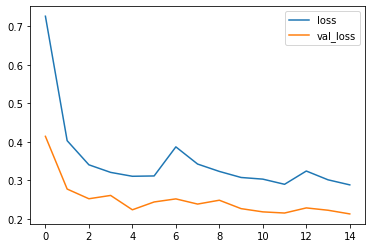

[I 2022-08-01 14:59:26,297] A new study created in memory with name: no-name-b21558bb-6a07-48aa-bbc6-4331ec3d3853
[I 2022-08-01 14:59:35,841] Trial 0 finished with value: 0.14447898119926367 and parameters: {'lambda_l1': 1.3172442390886886e-07, 'lambda_l2': 9.82639256840907e-08, 'num_leaves': 248, 'feature_fraction': 0.6443121926613724, 'bagging_fraction': 0.7121082683287776, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 0 with value: 0.14447898119926367.
[I 2022-08-01 14:59:45,402] Trial 1 finished with value: 0.1438633551619036 and parameters: {'lambda_l1': 0.01637333347319207, 'lambda_l2': 8.269545167873472e-06, 'num_leaves': 154, 'feature_fraction': 0.8556531098239367, 'bagging_fraction': 0.9948854824903433, 'bagging_freq': 4, 'min_child_samples': 79}. Best is trial 0 with value: 0.14447898119926367.
[I 2022-08-01 14:59:52,894] Trial 2 finished with value: 0.14470229652654132 and parameters: {'lambda_l1': 5.341374878503981e-07, 'lambda_l2': 4.206468137442055e-06, 'num_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12352
[LightGBM] [Info] Number of data points in the train set: 1081397, number of used features: 89
[LightGBM] [Info] Start training from score 2.841545


In [75]:

compare('f1')